In [1]:
import cv2
import torch
import time
import os
import glob

import numpy as np
np.bool = np.bool_

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

#os.environ["CUDA_VISIBLE_DEVICES"] = "2"


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  npv = onp.npv
/compuworks/anaconda3/envs/xaise

### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[06:18:03] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[06:18:03] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[06:18:03] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8204 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = False

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

[[391.75516 277.68097]
 [457.6281  245.2619 ]
 [468.77548 315.0861 ]
 [399.4387  374.28183]
 [458.98672 351.14188]]
[array([[391.75516, 277.68097],
       [457.6281 , 245.2619 ],
       [468.77548, 315.0861 ],
       [399.4387 , 374.28183],
       [458.98672, 351.14188]], dtype=float32)]


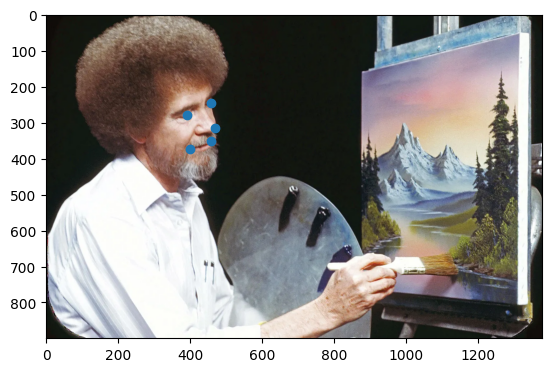

[[ 6.60495860e-01 -6.89346638e-02 -1.45022950e+02]
 [ 6.89346638e-02  6.60495860e-01 -9.97196038e+01]]
[[ 94.58786524 110.69303694]
 [140.33147705  93.82130716]
 [142.88096145 140.7083346 ]
 [ 93.00365895 175.02716721]
 [133.93003426 163.84824739]]


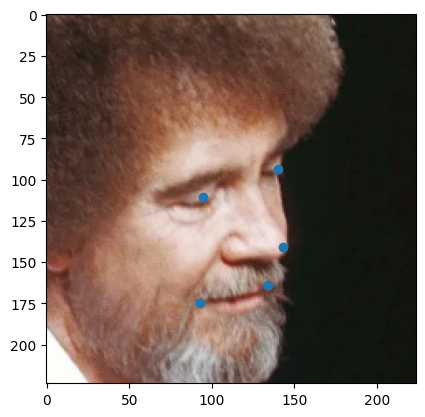

'\ntry:    \n    source = crop_face(source_full, app, crop_size)[0]\n    print(source.shape)\n    source = [source[:, :, ::-1]]\n    print("Everything is ok!")\nexcept TypeError:\n    print("Bad source images")\n'

In [7]:
# check, if we can detect face on the source image
from utils.inference.video_processing import smooth_landmarks

kps = app.get(source_full, crop_size)
print(kps[0])
smooth_kps = smooth_landmarks([kps], n=2)
print(smooth_kps[0])
import matplotlib.pyplot as plt


plt.imshow(source_full[:,:,::-1])
plt.scatter(kps[0][:, 0], kps[0][:, 1])
plt.show()
from insightface.utils import face_align
M, _ = face_align.estimate_norm(kps[0], crop_size, mode ='None') 
print(M)

kps_3 = np.ones([kps[0].shape[0], 3])

kps_3[:, :2] = kps[0]


M_kps = kps_3.dot(M.T)
print(M_kps)

# M = (2x3) Affine matrix
align_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)

plt.imshow(align_img[:,:,::-1])
plt.scatter(M_kps[:, 0], M_kps[:, 1])
plt.show()
source = [align_img]
"""
try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
"""